## Wordle Solver

Implementation time: 15h

### Libraries

In [1]:
import math
import numpy as np
import random as rd

### Wordle implementation

The following class implements the logic of the wordle. 

*   It stores the words that are accepted
*   It evaluates an input Word and returns an output useful for updating the rules



In [2]:
# Wordle
class WordleSim():
    """
    The simulation holds two dictionaries, one for winning words and one for 
    guessable words.
    """
    dictionary_winning = []
    dictionary_allowed = []
    board_width = 5
    board = np.ndarray(shape=(board_width, board_width + 1))

    def __init__(self):
        self.dictionary_winning = self.parse_dictionary("possible_words.txt")
        self.dictionary_allowed = self.parse_dictionary("allowed_words.txt")
        self.chosen_word = self.choose_word()
        
    def parse_dictionary(self, dictionary):
        #Parses a dictionary into a list of strings
        temp_dictionary = []
        lines = []
        with open(dictionary) as f:
            lines = f.readlines()

        for line in lines:
            temp_dictionary.append(line.strip())
        return temp_dictionary
    
    def choose_word(self):
        #randomise among words from dictionary_possible
        return Word(rd.choice(self.dictionary_winning))

    def update_word(self):
        #update chosen word 
        self.chosen_word = self.choose_word()

    def input_word(self):
        #receive input and return a response 
        guess = input("Enter a word: ")

        if guess in self.dictionary_allowed:
            evaluation = self.evaluate_guess(Word(guess))
            return(evaluation)
        else:
            print("not a valid word")
            self.input_word() 

    def evaluate_guess(self, guessed_word):
        #evaluates the accuracy of a guessed word
        evaluation = [0]*self.board_width
        correct_letters = self.chosen_word.letters.copy()
        guessed_letters = guessed_word.letters.copy() 
    
        #Right letter in right place:
        for i in range(self.board_width):
            if guessed_letters[i] == correct_letters[i]:
                evaluation[i] = 2
                guessed_letters[i] = ''
                correct_letters[i] = ''

        #Right letter in the wrong place                
        for i in range(self.board_width):
            if guessed_letters[i] != '' :
                if guessed_letters[i] in correct_letters:
                    evaluation[i] = 1
                    #get index in correct_letters
                    n = correct_letters.index(guessed_letters[i])
                    #replace
                    correct_letters[n] = ''

        print(evaluation)
        return evaluation


### Tree search logic
It consists of the __Words__, and the __Tree__ that return a word according to the state of the game. This last class performs a search for letter and position till a proposed word is filled. This is where the __LetterNodes__ and __PositionNodes__ come into play, which allow us to calculate entropies to decide what letters and positions are most suited for the state of the game.

The Tree is structured like this: Tree > LetterNodes > PositionNodes

__Word:__

All words are stored in this class, and allows us some functionalities to check letter by letter.

In [3]:
class Word:
  
  def __init__(self, name):
    self.name = name
    self.letters = [l for l in self.name]


  def get_index(self,letter):
    """
    collects the index(es) of the letter in the word
    """
    index = []
    for i in range(len(self.letters)):
      if letter == self.letters[i]:
        index.append(i)
    return index


  def is_complete(self):
    """
    returns false if there are letters to be filled
    """

    complete = True

    for letter in self.letters:
      complete = complete and letter != " "

    return complete

__Position Node__

In [ ]:
class PositionNode:

    def __init__(self, i):

      self.position = i
      self.words = []

    def get_num_words(self):
      return len(self.words)
  

__Letter Node__

In [ ]:
class LetterNode:

  def __init__(self, letter):
    self.letter = letter
    self.words = []
    self.entropy = float

    # For not creating useless position nodes
    self.completed_positions = []

    self.position_nodes = {}
  
  def fill(self, completed_positions):
    """
    fills its position nodes
    """

    self.completed_positions = completed_positions

    l = self.letter
    words = self.words
    
    # create all position nodes
    all_positions = list(set([pos for word in words for pos in word.get_index(l)]))
    
    for pos in all_positions:
      if pos not in completed_positions:
        self.position_nodes[pos] = PositionNode(pos)

    # assign each word a node
    for word in words:
      self.assign_node(word)

  def assign_node(self, word):
    """
    sends each word to its corresponding position node
    """

    l = self.letter

    # retrieve letter
    indexes = word.get_index(l)

    #insert into the nodes
    for index in indexes:
      if index not in self.completed_positions:
        self.position_nodes[index].words.append(word)


  def compute_statistics(self, num_total_words):
        """
        Calculates the entropy of the node.
        """

        #retrieve number of words in each letter node
        num_words_per_node = [node[1].get_num_words() for node in self.position_nodes.items()]

        # calculate probability, defined as num/
        prob_per_node = [num /num_total_words for num in num_words_per_node]

        #entropy calculation
        self.entropy = -sum([prob*math.log2(prob) for prob in prob_per_node])



__Tree__

In [ ]:
class Tree:
  
  def __init__(self, possible_words, remaining_letters, completed_positions):
    self.remaining_letters = remaining_letters
    self.completed_positions = completed_positions
    self.possible_words = possible_words

    self.guessed_word = Word("     ")

    self.words_filter = WordsFilter()
    

  def create_letter_nodes(self):
    self.letter_nodes = {l:LetterNode(l) for l in self.remaining_letters}


  def fill_letter_nodes(self):
    """
    fills up the letter nodes
    """

    for word in self.possible_words:
      self.assign_nodes(word)

    for item in self.letter_nodes.items():
      node = item[1]

      #we input the positions that are completed so that they do't create those nodes
      node.fill(self.completed_positions)

  def assign_nodes(self, word):
    """
    given a word it sends it to its letter node
    """

    for l in word.letters:
      self.letter_nodes[l].words.append(word)


  def compute_node_statistics(self):
    for item in self.letter_nodes.items():
      node = item[1]
      node.compute_statistics(len(self.possible_words))

  def retrieve_letter_position(self):

    letter = str()
    max_entropy = -100000000
    #retrieving the letter node with the higest entropy
    for item in self.letter_nodes.items():
      node = item[1]
      if node.position_nodes !={}:
        if node.entropy > max_entropy:
          letter = node.letter
          max_entropy = node.entropy
          max_node = node

    # retrieving the position of the chosen letter
    position = str()
    max_num_words = 0
    for item in max_node.position_nodes.items():
      node = item[1]
      num_words = node.get_num_words()

      if num_words > max_num_words:
        position = node.position
        max_num_words = num_words

    return letter, position

  def update_tree(self, result):
    
    letter = result[0]
    position = result[1]

    # updating guessed word
    self.guessed_word.letters[position] = letter

    # updating completed positions
    self.completed_positions.append(position)

    # words filter
    self.words_filter.has_letter_at_position.append((position, letter))
    self.possible_words = self.words_filter.filter(self.possible_words)

    # updating possible words
    words = [word.name for word in self.possible_words]
    self.remaining_letters = list(set([l for l in "".join(words)]))


  def guess_word(self):

    while not self.guessed_word.is_complete():
      self.create_letter_nodes()
      self.fill_letter_nodes()
      self.compute_node_statistics()
      result = self.retrieve_letter_position()
      self.update_tree(result)

    return self.guessed_word

### Guesser

In [ ]:
class Guesser:

  def __init__(self, possible_words, 
               remaining_letters = ["a", "b", "c", "d", "e", "f", "g", "h", "i",
                                    "j", "k", "l", "m", "n", "o", "p", "q", "r", 
                                    "s", "t", "u", "v", "w", "x", "y", "z"],
               completed_positions = []):
    
    self.remaining_letters = remaining_letters
    self.completed_positions = []
    self.possible_words = possible_words

    self.final_word = Word("     ")

    self.words_filter = WordsFilter()

  def guess(self):
    """
    Function that guesses the next word given the state
    """
    
    self.tree = Tree(possible_words = self.possible_words,
                      remaining_letters = self.remaining_letters,
                      completed_positions = self.completed_positions)
    result = self.tree.guess_word()

    self.completed_positions = []
      
    return result

  def update(self, guessed_word, update):
      """
      Updates the state according to the response of the tree
      """

      update = [(i,val) for i,val in enumerate(update)]
      for letter, rule in zip(guessed_word.letters, update):
        position = rule[0]
        val = rule[1]

        # it contains a letter at position position
        if val == 2:
          self.words_filter.has_letter_at_position.append((position,letter))
          self.final_word.letters[position] = letter

          # updating completed positions
          self.completed_positions.append(position)

        # it has another letter that it is not in a position
        elif val == 1:

          #the letter is not in that position
          self.words_filter.has_NOT_letter_at_position.append((position,letter))

          #But it has it
          if letter in self.final_word.letters:
            times = self.final_word.letters.count(letter)
            self.words_filter.contains_letter_more_than_x_times.append((letter,times))

          else:
            self.words_filter.contains_letter_more_than_x_times.append((letter,0))

        # it does not have any more of those letters
        else:
          times = 0
          if guessed_word.letters.count(letter)>1:
            #mirar quants 1 apareixen en la update
            for l, r in zip(guessed_word.letters, update):

              p = r[0]
              v = r[1]

              if l == letter:
                if v !=0:
                  times += 1

          # it does not have more letters present than the ones of the final word
            self.words_filter.NOT_contains_letter_more_than_x_times.append((letter,times))

          # it does not contain that letter at all
          else:
            self.words_filter.NOT_contains_letter_more_than_x_times.append((letter,times))


      # words filter and updating possible words
      self.possible_words = self.words_filter.filter(self.possible_words)

      # updating remaining letters
      words = [word.name for word in self.possible_words]
      self.remaining_letters = list(set([l for l in "".join(words)]))

      # we put completes_positions to [] again
      self.completed_positions = []
    


### Words Filter
This class implements the filter of the words. Given the rules that are updated when choosing letters of the words or from choosing a word for the solver, words are filtered out to narrow the search.

In [ ]:
class WordsFilter():

  def __init__(self):
    self.contains_letter_more_than_x_times = [] #letter, times
    self.NOT_contains_letter_more_than_x_times = [] #letter, times

    self.has_letter_at_position = [] #pos, letter
    self.has_NOT_letter_at_position = [] #pos, letter
    

  def filter(self, words):
    """
    returns the appropiate words given the filters
    """
    
    filtered_words = []

    for word in words:
      good = True
      #check if it has letter l at position pos
      for rule in self.has_letter_at_position:
        pos = rule[0]
        l = rule[1]
        if not word.letters[pos] == l:
          good = False

      #check if it DOES NOT HAVE letter l at position pos
      if good:
        for rule in self.has_NOT_letter_at_position:
          pos = rule[0]
          l = rule[1]
          if word.letters[pos] == l:
            good = False
      
      #check if word has letter contains
      if good:
        for rule in self.contains_letter_more_than_x_times:
          l = rule[0]
          times = rule[1]
          if word.letters.count(l) <= times:
            good = False
      
      #check if word has letter not_contains
      if good:
        for rule in self.NOT_contains_letter_more_than_x_times:
          l = rule[0]
          times = rule[1]
          if word.letters.count(l) > times:
            good = False

      if good:
        filtered_words.append(word)

    return filtered_words



### Wordle Solver

Class that implements the logic for running iterations of the Wordle game and its guesser. 

In [ ]:
### Skeleton code for main program
class WordleSolver(): 
    
    #Initiate search tree, wordle simulator, and dictionaries. Also define root
    def __init__(self):
        self.wordle_sim = WordleSim()
        self.possible_words = [Word(word) for word in self.wordle_sim.dictionary_allowed]
        self.guesser = Guesser(self.possible_words)

        self.solved = False
        self.num_opportunities = 6
        
    #Simulates a Wordle session and tries to solve it with our search tree.
    def run(self, iterations = 1):

        iter = 0
        total_tries = []
        while iter<iterations:

            num_tries = 0
            while (not self.solved):
                #Choose a word through the search tree
                guess = self.guesser.guess()
                print(guess.letters)
                num_tries +=1

                #evaluate guess
                evaluation = self.wordle_sim.evaluate_guess(guess)

                # Check if it is correct or keep updating
                if sum(evaluation) == 10:
                    print(guess.name)
                    self.solved = True                
                else:
                    self.guesser.update(guess, evaluation)

            total_tries.append(num_tries)
            
            iter += 1
            print(iter)
            self.wordle_sim.update_word()
            self.guesser = Guesser(self.possible_words)
            self.solved = False

        return total_tries


## Runner program

Iterating the solver 1000 times and evaluating its performance

In [ ]:
wordle_solver = WordleSolver()

In [ ]:
import time
start = time.time()
iterations = wordle_solver.run(iterations=1000)
print("time: ", time.time()-start)

Streaming output truncated to the last 5000 lines.
[1, 0, 0, 0, 2]
['u', 's', 'q', 'u', 'e']
[0, 2, 0, 2, 2]
['i', 's', 's', 'u', 'e']
[2, 2, 2, 2, 2]
     
599
['r', 'a', 'r', 'e', 'r']
[0, 1, 0, 0, 2]
['f', 'i', 'l', 'a', 'r']
[0, 0, 2, 2, 2]
['m', 'y', 'l', 'a', 'r']
[2, 0, 2, 2, 2]
['m', 'o', 'l', 'a', 'r']
[2, 2, 2, 2, 2]
     
600
['r', 'a', 'r', 'e', 'r']
[0, 0, 0, 1, 0]
['y', 'e', 'l', 't', 's']
[0, 1, 1, 0, 0]
['p', 'l', 'e', 'b', 'e']
[0, 2, 0, 0, 2]
['g', 'l', 'o', 'd', 'e']
[0, 2, 2, 0, 2]
['c', 'l', 'o', 'n', 'e']
[2, 2, 2, 2, 2]
     
601
['r', 'a', 'r', 'e', 'r']
[0, 0, 2, 2, 0]
['s', 'o', 'r', 'e', 's']
[0, 0, 2, 2, 0]
['d', 'u', 'r', 'e', 'd']
[0, 0, 2, 2, 0]
['t', 'h', 'r', 'e', 'w']
[2, 2, 2, 2, 2]
     
602
['r', 'a', 'r', 'e', 'r']
[0, 0, 2, 0, 0]
['s', 'o', 'r', 't', 's']
[0, 2, 2, 1, 0]
['t', 'o', 'r', 'c', 'h']
[2, 2, 2, 2, 2]
     
603
['r', 'a', 'r', 'e', 'r']
[0, 0, 0, 1, 0]
['y', 'e', 'l', 't', 's']
[0, 1, 0, 0, 0]
['g', 'i', 'n', 'g', 'e']
[0, 1, 2, 0, 1]
[

In [ ]:
import collections

counter=collections.Counter(iterations)
print(counter)

Counter({5: 329, 4: 260, 6: 197, 7: 103, 3: 50, 8: 36, 10: 8, 9: 7, 2: 7, 11: 3})


(array([  7.,  50., 260., 329., 197., 103.,  36.,   7.,  11.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <a list of 9 Patch objects>)

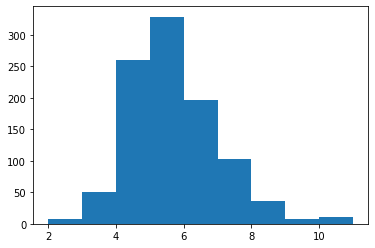

In [ ]:
import matplotlib.pyplot as plt

plt.hist(iterations, bins=9)

In [ ]:
#mean number of guesses
np.mean(iterations)

5.216

In [ ]:
#win rate:
num_wins= 0
for num in iterations:
  if num < 7:
    num_wins +=1

num_wins/1000

0.843